In [2]:
def graficoxG(id_partido):
   
    import pandas as pd
    import numpy
    #Leemos el archivo de eventos
    events='https://raw.githubusercontent.com/gonzalo09002/open-data/81bb27062e43874a1bdb72be9d243e93a8212dbc/data/events/{}.json'.format(id_partido)
    cargadatos=pd.read_json(events)

    #Leemos el archivo de las jornadas, y le añadimos la columna unión
    matches=pd.read_json('https://raw.githubusercontent.com/gonzalo09002/open-data/81bb27062e43874a1bdb72be9d243e93a8212dbc/data/matches/37/42.json')
    matches['union']=range(len(matches))
    
    #Separamos los datos de la columna home_team y le añadimos la columna union
    local1=matches['home_team'].apply(pd.Series)
    local1['union']=range(len(matches))

    #Unimos los dataframes 
    local2=pd.merge(matches, local1,how='outer',on='union')

    #Nos quedamos con la fila correspondiente al partido y seleccionamos el nombre del equipo local para guardarlo en su variable
    fila1=local2.loc[local2['match_id']==id_partido]
    local=fila1.iloc[0,-5]

    #Mismo proceso para equipo visitante
    visit1=matches['away_team'].apply(pd.Series)
    visit1['union']=range(len(matches))
    visit2=pd.merge(matches, visit1,how='outer',on='union')
    fila2=visit2.loc[visit2['match_id']==id_partido]
    visitante=fila2.iloc[0,-5]

    goleslocal=fila1.iloc[0,7]
    golesvisitante=fila1.iloc[0,8]
    
    #Jornada
    jornada=fila1.iloc[0,12]
    fecha=fila1.iloc[0,1]
    
    #Nos quedamos con los eventos que se refieren a los tiros
    tiros=cargadatos.loc[cargadatos['type']=={'id': 16, 'name': 'Shot'}].dropna(axis=1)
    
    #Expandimos la columna que incluye la información referente a los tiros
    dfdatostiros=pd.concat([tiros,tiros['shot'].apply(pd.Series)],axis=1).drop(columns=['shot'])
    
    #Expandimos la columna location para obtener las coordenadas de cada disparo
    dfconcoord= pd.DataFrame(dfdatostiros['location'].values.tolist())
    
    #Añadimos una columna a cada dataframe para que nos sirva de índice para el merge
    dfconcoord['union']=range(len(dfconcoord))
    dfdatostiros['union']=range(len(dfconcoord))
    
    #Unimos los dataframes para quedarnos con uno que incluya la localización del tiro
    dfbueno=pd.merge(dfconcoord, dfdatostiros, how='outer', on='union')
    
    #Separamos los datos del equipo con posesión para olvidarnos del id y quedarnos con el name
    posesionsep=dfbueno['team'].apply(pd.Series)
    posesionsep['union']=range(len(dfbueno))
    dfbueno=pd.merge(dfbueno, posesionsep,how='outer',on='union')
    
    #Renombramos las columnas de las coordenadas
    dfbueno.rename(columns={0: 'x', 1: 'y'},inplace=True)   
    
    #Ajustamos la y a las coordenadas de StatsBomb
    dfbueno['y']=80-(dfbueno['y'])
    
    #Colocamos los puntos del equipo local a la izquierda
    dfbueno['x'] = numpy.where(dfbueno['name'] == local , 120-(dfbueno['x']), dfbueno['x'])
    
    #Suma de los xG acumulados de cada equipo
    xGLocTotal=dfbueno.loc[dfbueno['name'] == local, 'statsbomb_xg'].sum()
    xGVisTotal=dfbueno.loc[dfbueno['name'] == visitante, 'statsbomb_xg'].sum()
    xGLocTotal=round(xGLocTotal, 2)
    xGVisTotal=round(xGVisTotal, 2)
    
    #Para calcular tiros y tiros a puerta
    tiros[['idequipo','name']] =pd.DataFrame(tiros.team.values.tolist(),index=tiros.index)
    hola=tiros['shot'].apply(pd.Series)
    ey=list(hola)
    tiros[ey]=pd.DataFrame(tiros.shot.values.tolist(),index=tiros.index)
    tiros[['resultado','idresultado']]=pd.DataFrame(tiros.outcome.values.tolist(),index=tiros.index)
    
    #Dataframe con los tiros locales
    dftiroslocal=tiros[tiros['name']==local]

    #Dataframe con los tiros visitantes
    dftirosvisitante=tiros[tiros['name']==visitante]

    #Locales
    tiroslocal=len(dftiroslocal)
    dftirosapuertalocal=dftiroslocal[(dftiroslocal['idresultado']=="Saved") | (dftiroslocal['idresultado']=="Goal")  | (dftiroslocal['idresultado']=="Saved to Post") | (dftiroslocal['idresultado']=="Post") ]
    tirosapuertalocal=len(dftirosapuertalocal)
    if tiroslocal == 0:
        porcentajelocal=0
        xGlocalpordisparo="-"
    else:
        porcentajelocal=(tirosapuertalocal/tiroslocal)*100
        porcentajelocal=round(porcentajelocal,1)
        xGlocalpordisparo=xGLocTotal/tiroslocal
        xGlocalpordisparo=round(xGlocalpordisparo,2)
    if goleslocal == 0:
        tirosporgollocal= "-"
    else:
        tirosporgollocal=tiroslocal/goleslocal
        tirosporgollocal=round(tirosporgollocal,2)

    #Visitantes
    tirosvisitante=len(dftirosvisitante)
    dftirosapuertavisitante=dftirosvisitante[(dftirosvisitante['idresultado']=="Saved") | (dftirosvisitante['idresultado']=="Goal")  | (dftirosvisitante['idresultado']=="Saved to Post") | (dftirosvisitante['idresultado']=="Post") ]
    tirosapuertavisitante=len(dftirosapuertavisitante)
    if tirosvisitante == 0:
        porcentajevisitante=0
        xGvisitantepordisparo="-"
    else:
        porcentajevisitante=(tirosapuertavisitante/tirosvisitante)*100
        porcentajevisitante=round(porcentajevisitante,1)
        xGvisitantepordisparo=xGVisTotal/tirosvisitante
        xGvisitantepordisparo=round(xGvisitantepordisparo,2)
    if golesvisitante == 0:
        tirosporgolvisitante= "-"
    else:
        tirosporgolvisitante=tirosvisitante/golesvisitante
        tirosporgolvisitante=round(tirosporgolvisitante,2)
        #Dibujamos el gráfico
    
    import matplotlib.pyplot as plt
    from matplotlib.patches import Arc

    posicionxG=dfbueno.columns.get_loc("statsbomb_xg")
    posicionx=dfbueno.columns.get_loc("x")
    posiciony=dfbueno.columns.get_loc("y")
    posicionequipo=dfbueno.columns.get_loc("name")

    fig, ax = plt.subplots(figsize=(18,14))
    for i in range(len(dfbueno)):
        if dfbueno.iloc[i,posicionequipo] == local:
            plt.scatter(x=dfbueno.iloc[i,posicionx],y=dfbueno.iloc[i,posiciony],s = dfbueno.iloc[i,posicionxG]*500,c='#CC0000')
        if dfbueno.iloc[i,posicionequipo] == visitante:
            plt.scatter(x=dfbueno.iloc[i,posicionx],y=dfbueno.iloc[i,posiciony],s = dfbueno.iloc[i,posicionxG]*500,c='#7500AC')

    #StatsBomb Pitch
    # Pitch Outline & Centre Line 
    plt.plot([0,0],[0,80], color="black")
    plt.plot([0,120],[80,80], color="black") 
    plt.plot([120,120],[80,0], color="black")
    plt.plot([120,0],[0,0], color="black")
    plt.plot([60,60],[80,0], color="black")

    # Left Penalty Area
    plt.plot([0,18],[62,62],color="black")
    plt.plot([0,18],[18,18],color="black")
    plt.plot([18,18],[18,62],color="black")

    # Right Penalty Area
    plt.plot([120,102],[62,62],color="black")
    plt.plot([120,102],[18,18],color="black")
    plt.plot([102,102],[18,62],color="black")

    # Left 6-yard Box
    plt.plot([0,6],[50,50],color="black")
    plt.plot([0,6],[30,30],color="black")
    plt.plot([6,6],[50,30],color="black")

    # Right 6-yard Box 
    plt.plot([120,114],[30,30],color="black")
    plt.plot([120,114],[50,50],color="black")
    plt.plot([114,114],[30,50],color="black")

    # Prepare Circles OK
    centreCircle = plt.Circle((60,40),9.15,color="black",fill=False)
    centreSpot = plt.Circle((60,40),0.6,color="black")
    leftPenSpot = plt.Circle((12,40),0.6,color="black")
    rightPenSpot = plt.Circle((108,40),0.6,color="black")

    # Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)

    # Prepare Arcs based on penalty Spots 
    leftArc = Arc((12,40),height=18.3,width=18.3,angle=0,theta1=310,theta2=50,color="black")
    rightArc = Arc((108,40),height=18.3,width=18.3,angle=0,theta1=130,theta2=230,color="black")


    # Draw Arcs
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)
    
    #Cuadros de texto
    ax.text(3, 64, s = "{} \n\n Disparos: {} \n Disparos a puerta: {} \n %SoT: {} % \n Disparos/Gol: {} \n xG acumulado: {} \n xG/Disparo: {}".format(local, tiroslocal, tirosapuertalocal, porcentajelocal, tirosporgollocal, xGLocTotal, xGlocalpordisparo), rotation = 0, size = 15, bbox=dict(facecolor='#CC0000', alpha=0.2), ha='left',family='bahnschrift')
    ax.text(117, 64, s = "{} \n\n Disparos: {} \n Disparos a puerta: {} \n %SoT: {} % \n Disparos/Gol: {} \n xG acumulado: {} \n xG/Disparo: {}".format(visitante, tirosvisitante, tirosapuertavisitante, porcentajevisitante, tirosporgolvisitante, xGVisTotal, xGvisitantepordisparo), rotation = 0, size = 15, bbox=dict(facecolor='#7500AC', alpha=0.2), ha='right', family='bahnschrift')
    ax.text(60, 95, s = "Jornada {} \n {}".format(jornada,fecha), rotation = 0, size = 15, bbox=dict(facecolor='#D0D0D0', alpha=0.8), ha='center', family='bahnschrift')
    ax.text(0, 90, s = " {}: {}".format(local,goleslocal), size = 35, color='#CC0000', ha='left', family='bahnschrift')
    ax.text(0, 85, s = " {}: {}".format(visitante,golesvisitante), size = 35, color='#7500AC', ha='left', family='bahnschrift')
   
    #Leyenda
    g2 = plt.scatter([],[], s=50, marker='o', color='#555555',alpha=0.8)
    g3 = plt.scatter([],[], s=150, marker='o', color='#555555',alpha=0.8)
    g4 = plt.scatter([],[], s=250, marker='o', color='#555555',alpha=0.8)
    g5 = plt.scatter([],[], s=350, marker='o', color='#555555',alpha=0.8)


    plt.legend((g2,g3,g4,g5),
       ('0.1', '0.3','0.5','0.7'),
       scatterpoints=1,title='Valor de los xG',
       loc=(0.385,0.85),
       ncol=5, prop=dict(family='bahnschrift',weight=500),
       title_fontsize=15,
       labelspacing=1,framealpha=1,edgecolor='black',borderpad=1)
    plt.axis("off")
    plt.show()

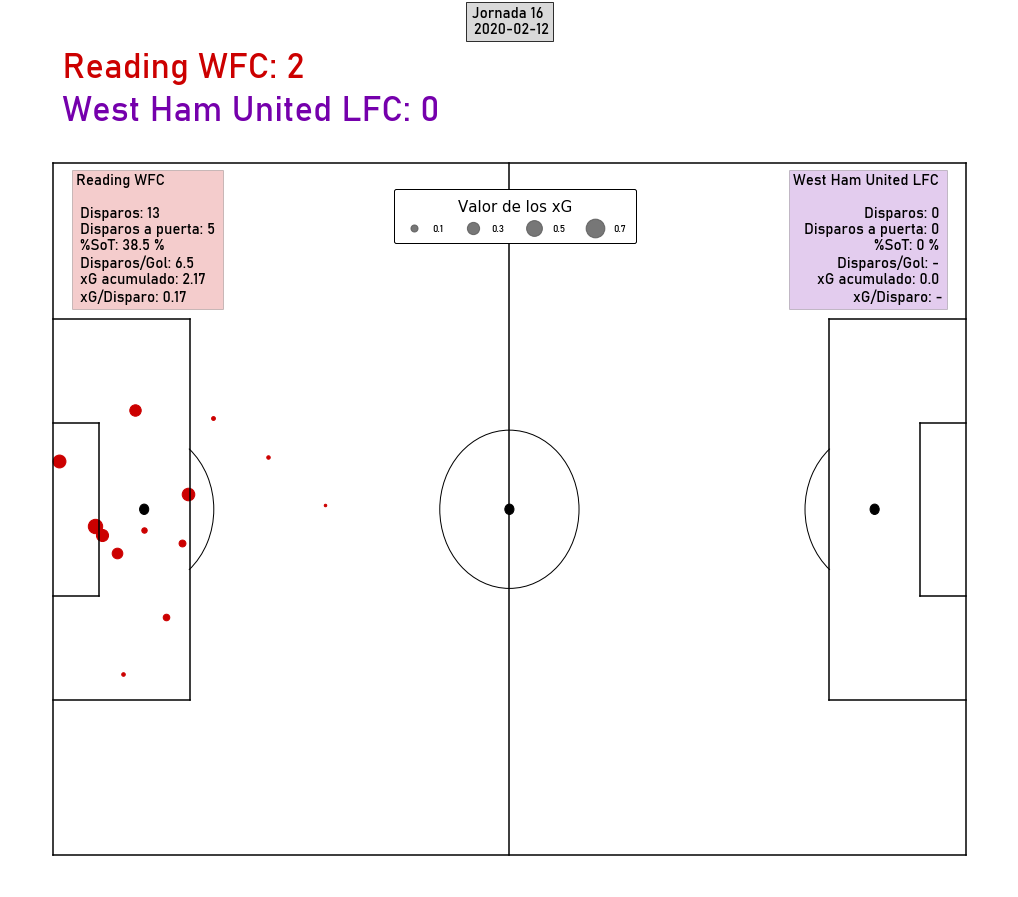

In [4]:
graficoxG(2275038)

In [ ]:
import pandas as pd
import numpy

id_partido=2275086
#Leemos el archivo de eventos
events='https://raw.githubusercontent.com/gonzalo09002/open-data/81bb27062e43874a1bdb72be9d243e93a8212dbc/data/events/{}.json'.format(id_partido)
cargadatos=pd.read_json(events)

#Leemos el archivo de las jornadas, y le añadimos la columna unión
matches=pd.read_json('https://raw.githubusercontent.com/gonzalo09002/open-data/81bb27062e43874a1bdb72be9d243e93a8212dbc/data/matches/37/42.json')
matches['union']=range(len(matches))

#Separamos los datos de la columna home_team y le añadimos la columna union
local1=matches['home_team'].apply(pd.Series)
local1['union']=range(len(matches))

#Unimos los dataframes 
local2=pd.merge(matches, local1,how='outer',on='union')

#Nos quedamos con la fila correspondiente al partido y seleccionamos el nombre del equipo local para guardarlo en su variable
fila1=local2.loc[local2['match_id']==id_partido]
local=fila1.iloc[0,-5]

#Mismo proceso para equipo visitante
visit1=matches['away_team'].apply(pd.Series)
visit1['union']=range(len(matches))
visit2=pd.merge(matches, visit1,how='outer',on='union')
fila2=visit2.loc[visit2['match_id']==id_partido]
visitante=fila2.iloc[0,-5]

goleslocal=fila1.iloc[0,7]
golesvisitante=fila1.iloc[0,8]

#Jornada
jornada=fila1.iloc[0,12]
fecha=fila1.iloc[0,1]

    #Nos quedamos con los eventos que se refieren a los tiros
tiros=cargadatos.loc[cargadatos['type']=={'id': 16, 'name': 'Shot'}].dropna(axis=1)
    
    #Expandimos la columna que incluye la información referente a los tiros
dfdatostiros=pd.concat([tiros,tiros['shot'].apply(pd.Series)],axis=1).drop(columns=['shot'])
    
    #Expandimos la columna location para obtener las coordenadas de cada disparo
dfconcoord= pd.DataFrame(dfdatostiros['location'].values.tolist())
    
    #Añadimos una columna a cada dataframe para que nos sirva de índice para el merge
dfconcoord['union']=range(len(dfconcoord))
dfdatostiros['union']=range(len(dfconcoord))
    
    #Unimos los dataframes para quedarnos con uno que incluya la localización del tiro
dfbueno=pd.merge(dfconcoord, dfdatostiros, how='outer', on='union')
    
    #Separamos los datos del equipo con posesión para olvidarnos del id y quedarnos con el name
posesionsep=dfbueno['team'].apply(pd.Series)
posesionsep['union']=range(len(dfbueno))
dfbueno=pd.merge(dfbueno, posesionsep,how='outer',on='union')
    
    #Renombramos las columnas de las coordenadas
dfbueno.rename(columns={0: 'x', 1: 'y'},inplace=True)   
    
    #Ajustamos la y a las coordenadas de StatsBomb
dfbueno['y']=80-(dfbueno['y'])

    
    #Colocamos los puntos del equipo local a la izquierda
dfbueno['x'] = numpy.where(dfbueno['name'] == local , 120-(dfbueno['x']), dfbueno['x'])

#xG local y visitante redondeando los decimales
xGLocTotal=dfbueno.loc[dfbueno['name'] == local, 'statsbomb_xg'].sum()
xGVisTotal=dfbueno.loc[dfbueno['name'] == visitante, 'statsbomb_xg'].sum()
xGLocTotal=round(xGLocTotal, 2)
xGVisTotal=round(xGVisTotal, 2)


#Para calcular tiros y tiros a puerta
tiros[['idequipo','name']] =pd.DataFrame(tiros.team.values.tolist(),index=tiros.index)
hola=tiros['shot'].apply(pd.Series)
ey=list(hola)
tiros[ey]=pd.DataFrame(tiros.shot.values.tolist(),index=tiros.index)
tiros[['resultado','idresultado']]=pd.DataFrame(tiros.outcome.values.tolist(),index=tiros.index)

#Dataframe con los tiros locales
dftiroslocal=tiros[tiros['name']==local]

#Dataframe con los tiros visitantes
dftirosvisitante=tiros[tiros['name']==visitante]

#Locales
tiroslocal=len(dftiroslocal)
dftirosapuertalocal=dftiroslocal[(dftiroslocal['idresultado']=="Saved") | (dftiroslocal['idresultado']=="Goal")  | (dftiroslocal['idresultado']=="Saved to Post") | (dftiroslocal['idresultado']=="Post") ]
tirosapuertalocal=len(dftirosapuertalocal)
if tiroslocal == 0:
    porcentajelocal=0
    xGlocalpordisparo="-"
else:
    porcentajelocal=(tirosapuertalocal/tiroslocal)*100
    porcentajelocal=round(porcentajelocal,1)
    xGlocalpordisparo=xGLocTotal/tiroslocal
    xGlocalpordisparo=round(xGlocalpordisparo,2)
if goleslocal == 0:
    tirosporgollocal= "-"
else:
    tirosporgollocal=tiroslocal/goleslocal
    tirosporgollocal=round(tirosporgollocal,2)

#Visitantes
tirosvisitante=len(dftirosvisitante)
dftirosapuertavisitante=dftirosvisitante[(dftirosvisitante['idresultado']=="Saved") | (dftirosvisitante['idresultado']=="Goal")  | (dftirosvisitante['idresultado']=="Saved to Post") | (dftirosvisitante['idresultado']=="Post") ]
tirosapuertavisitante=len(dftirosapuertavisitante)
if tirosvisitante == 0:
    porcentajevisitante=0
    xGvisitantepordisparo="-"
else:
    porcentajevisitante=(tirosapuertavisitante/tirosvisitante)*100
    porcentajevisitante=round(porcentajevisitante,1)
    xGvisitantepordisparo=xGVisTotal/tirosvisitante
    xGvisitantepordisparo=round(xGvisitantepordisparo,2)
if golesvisitante == 0:
    tirosporgolvisitante= "-"
else:
    tirosporgolvisitante=tirosvisitante/golesvisitante
    tirosporgolvisitante=round(tirosporgolvisitante,2)


import matplotlib.pyplot as plt
from matplotlib.patches import Arc

posicionxG=dfbueno.columns.get_loc("statsbomb_xg")
posicionx=dfbueno.columns.get_loc("x")
posiciony=dfbueno.columns.get_loc("y")
posicionequipo=dfbueno.columns.get_loc("name")


fig, ax = plt.subplots(figsize=(18,14))
for i in range(len(dfbueno)):
    if dfbueno.iloc[i,posicionequipo] == local:
        size=dfbueno.iloc[i,posicionxG]*500
        ax.scatter(x=dfbueno.iloc[i,posicionx],y=dfbueno.iloc[i,posiciony],s = size,c='#CC0000')
    if dfbueno.iloc[i,posicionequipo] == visitante:
        size=dfbueno.iloc[i,posicionxG]*500
        ax.scatter(x=dfbueno.iloc[i,posicionx],y=dfbueno.iloc[i,posiciony],s = size,c='#7500AC')

#StatsBomb Pitch
# Pitch Outline & Centre Line 
plt.plot([0,0],[0,80], color="black")
plt.plot([0,120],[80,80], color="black") 
plt.plot([120,120],[80,0], color="black")
plt.plot([120,0],[0,0], color="black")
plt.plot([60,60],[80,0], color="black")

# Left Penalty Area
plt.plot([0,18],[62,62],color="black")
plt.plot([0,18],[18,18],color="black")
plt.plot([18,18],[18,62],color="black")

# Right Penalty Area
plt.plot([120,102],[62,62],color="black")
plt.plot([120,102],[18,18],color="black")
plt.plot([102,102],[18,62],color="black")

# Left 6-yard Box
plt.plot([0,6],[50,50],color="black")
plt.plot([0,6],[30,30],color="black")
plt.plot([6,6],[50,30],color="black")

# Right 6-yard Box 
plt.plot([120,114],[30,30],color="black")
plt.plot([120,114],[50,50],color="black")
plt.plot([114,114],[30,50],color="black")

# Prepare Circles OK
centreCircle = plt.Circle((60,40),9.15,color="black",fill=False)
centreSpot = plt.Circle((60,40),0.6,color="black")
leftPenSpot = plt.Circle((12,40),0.6,color="black")
rightPenSpot = plt.Circle((108,40),0.6,color="black")

# Draw Circles
ax.add_patch(centreCircle)
ax.add_patch(centreSpot)
ax.add_patch(leftPenSpot)
ax.add_patch(rightPenSpot)

# Prepare Arcs based on penalty Spots 
leftArc = Arc((12,40),height=18.3,width=18.3,angle=0,theta1=310,theta2=50,color="black")
rightArc = Arc((108,40),height=18.3,width=18.3,angle=0,theta1=130,theta2=230,color="black")


# Draw Arcs
ax.add_patch(leftArc)
ax.add_patch(rightArc)
    
ax.text(3, 64, s = "{} \n\n Disparos: {} \n Disparos a puerta: {} \n %SoT: {} % \n Disparos/Gol: {} \n xG acumulado: {} \n xG/Disparo: {}".format(local, tiroslocal, tirosapuertalocal, porcentajelocal, tirosporgollocal, xGLocTotal, xGlocalpordisparo), rotation = 0, size = 15, bbox=dict(facecolor='#CC0000', alpha=0.2), ha='left',family='bahnschrift')
ax.text(117, 64, s = "{} \n\n Disparos: {} \n Disparos a puerta: {} \n %SoT: {} % \n Disparos/Gol: {} \n xG acumulado: {} \n xG/Disparo: {}".format(visitante, tirosvisitante, tirosapuertavisitante, porcentajevisitante, tirosporgolvisitante, xGVisTotal, xGvisitantepordisparo), rotation = 0, size = 15, bbox=dict(facecolor='#7500AC', alpha=0.2), ha='right', family='bahnschrift')
ax.text(60, 85, s = "Jornada {} \n {}".format(jornada,fecha), rotation = 0, size = 15, bbox=dict(facecolor='#D0D0D0', alpha=0.8), ha='center', family='bahnschrift')


g2 = plt.scatter([],[], s=50, marker='o', color='#555555',alpha=0.8)
g3 = plt.scatter([],[], s=150, marker='o', color='#555555',alpha=0.8)
g4 = plt.scatter([],[], s=250, marker='o', color='#555555',alpha=0.8)
g5 = plt.scatter([],[], s=300, marker='o', color='#555555',alpha=0.8)


plt.legend((g2,g3,g4,g5),
       ('0.1', '0.3','0.5','0.6'),
       scatterpoints=1,title='xG',
       loc=(0.385,0.85),
       ncol=5, prop=dict(family='bahnschrift',weight=500),
       title_fontsize=15,
       labelspacing=1,framealpha=1,edgecolor='black',borderpad=1)

plt.axis("off")
plt.show()